<a href="https://colab.research.google.com/github/MuhamedIbraHim7/Banking_Analytics_Project/blob/main/Bank_Churn_Complete_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 1. Introduction and Business Understanding

### Purpose
This project aims to predict customer churn in a bank — identifying which customers are likely to leave the service. Early identification enables the bank to deploy proactive retention strategies and reduce potential revenue loss.

### Problem Statement
Customer churn poses a significant financial risk. By leveraging machine learning, we aim to model churn behavior and predict customer attrition using available customer features.

### Dataset Overview
We assume the dataset includes customer demographics, account details, and transaction patterns. The target variable is `churn`, indicating whether a customer has left the bank.

### Success Metrics
- Classification metrics: Accuracy, Precision, Recall, F1-score, ROC-AUC
- Business metrics: Reduction in churn rate, improved retention efforts


In [ ]:
# ## 1. Introduction and Business Understanding
#
# ### Purpose
# Predict which bank customers are likely to churn (leave the bank), enabling
# proactive retention strategies and reducing revenue loss.

In [ ]:
# ## 2. Data Loading and Exploration

# ### 2.1 Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import shap
import joblib

In [ ]:
# Set styles
plt.rcParams['figure.figsize'] = (8, 5)

# ### 2.2 Load Dataset
df = pd.read_csv("churn_prediction_data.csv")

# strip whitespace and lowercase everything
df.columns = df.columns.str.strip().str.lower()

# show exactly what columns remain
print("Columns in df:", list(df.columns))

# ### 2.3 Initial Inspection
print(df.shape)
print(df.info())
print(df.describe(include='all'))

Columns in df: ['customerid', 'tenure', 'number_of_accounts', 'total_balance', 'frequency', 'monetary', 'recency', 'has_active_loan', 'number_of_cards', 'support_call_frequency', 'resolution_rate', 'churn']
(5000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customerid              5000 non-null   int64  
 1   tenure                  5000 non-null   int64  
 2   number_of_accounts      5000 non-null   float64
 3   total_balance           5000 non-null   float64
 4   frequency               5000 non-null   float64
 5   monetary                5000 non-null   float64
 6   recency                 5000 non-null   float64
 7   has_active_loan         5000 non-null   int64  
 8   number_of_cards         5000 non-null   float64
 9   support_call_frequency  5000 non-null   float64
 10  resolution_rate         5000 non-n

In [ ]:
# If there is anything like 'churn ' or ' churn' or 'Churn', force-rename it:
if 'churn' not in df.columns:
    # try to find any that contains 'churn'
    candidates = [c for c in df.columns if 'churn' in c]
    if candidates:
        # pick the first one and rename it
        real_name = candidates[0]
        df.rename(columns={real_name: 'churn'}, inplace=True)
        print(f"Renamed column {real_name!r} → 'churn'")
    else:
        raise KeyError("No column matching 'churn' found after cleaning.")

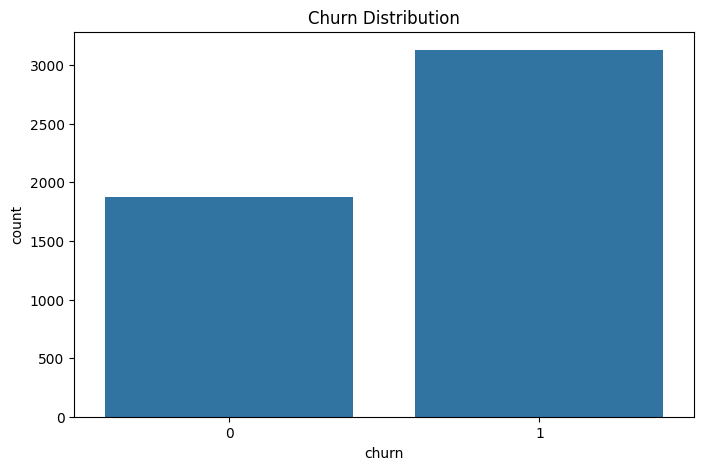

In [ ]:
# ## 3. Exploratory Data Analysis (EDA)

# ### 3.1 Target Distribution
sns.countplot(data=df , x='churn')
plt.title('Churn Distribution')
plt.show()

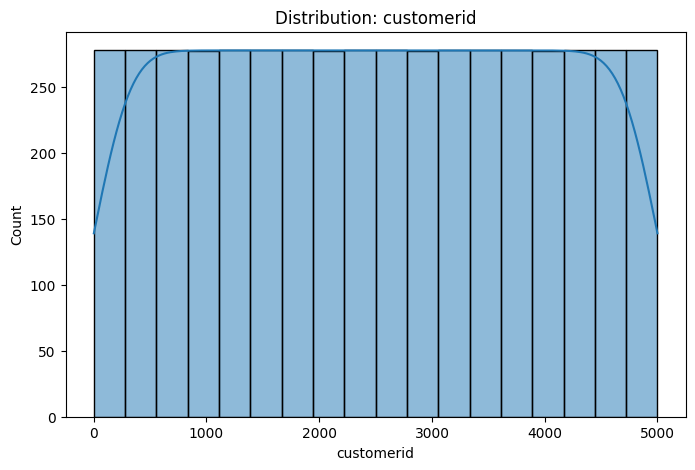

customerid: 0.00% missing


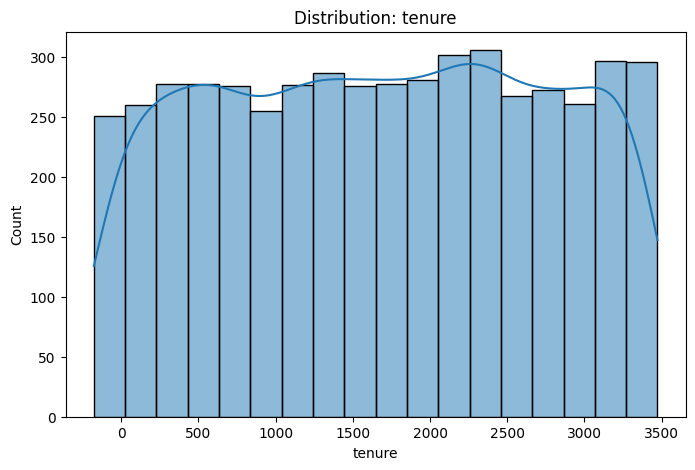

tenure: 0.00% missing


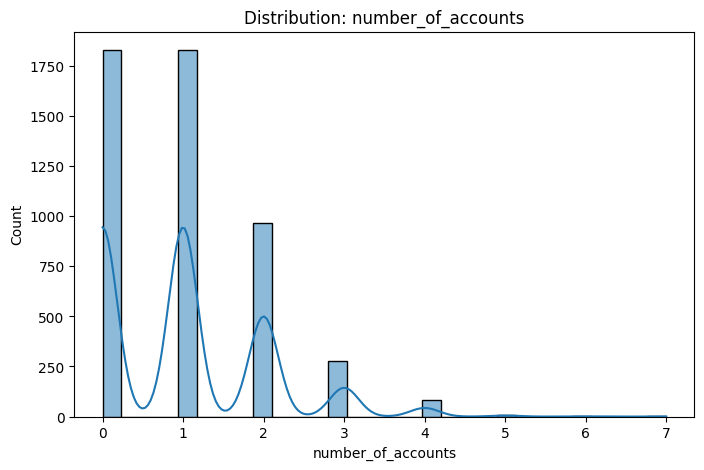

number_of_accounts: 0.00% missing


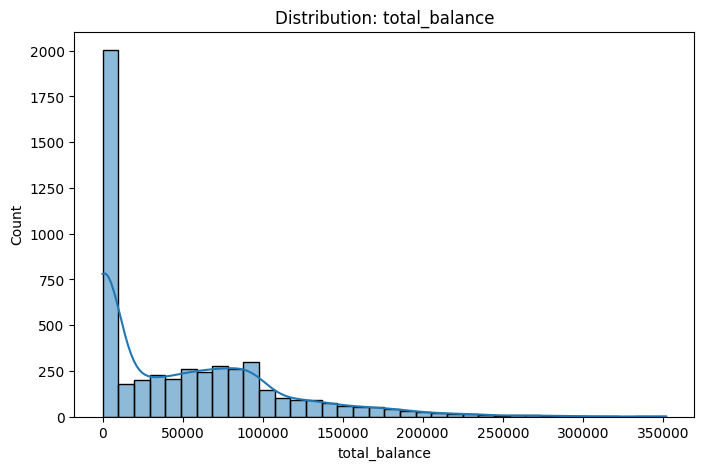

total_balance: 0.00% missing


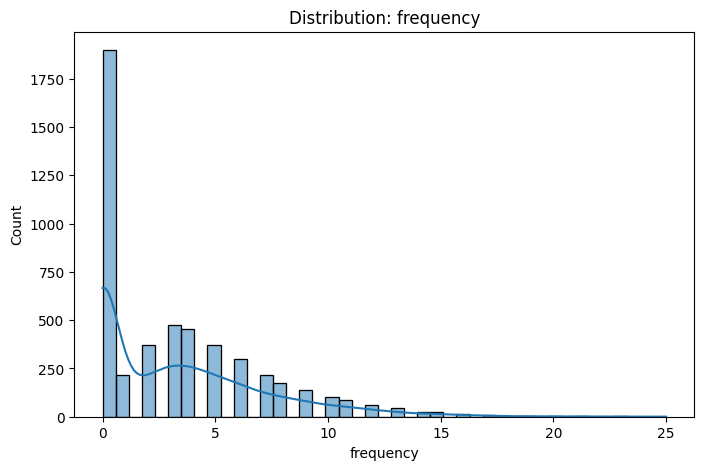

frequency: 0.00% missing


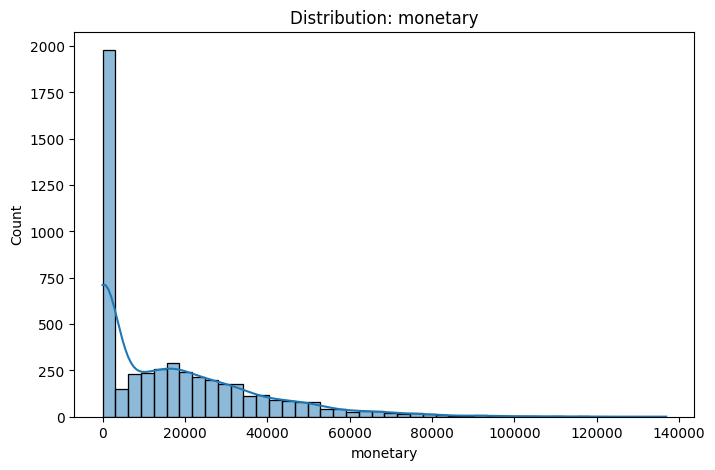

monetary: 0.00% missing


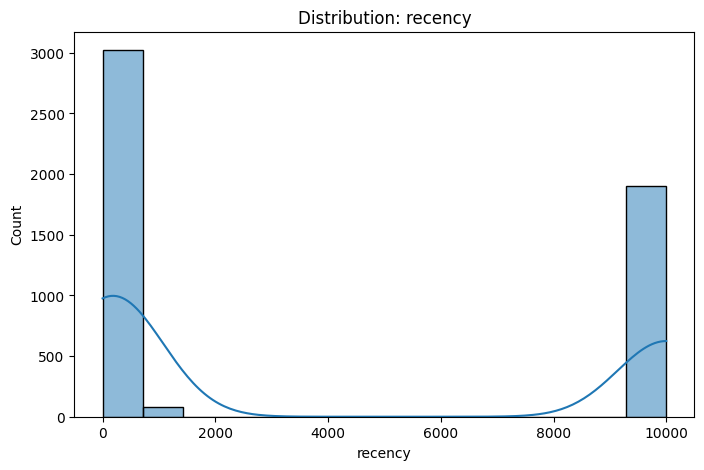

recency: 0.00% missing


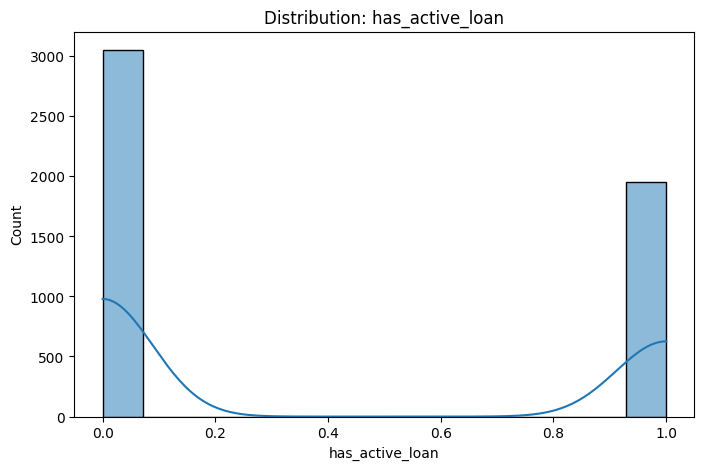

has_active_loan: 0.00% missing


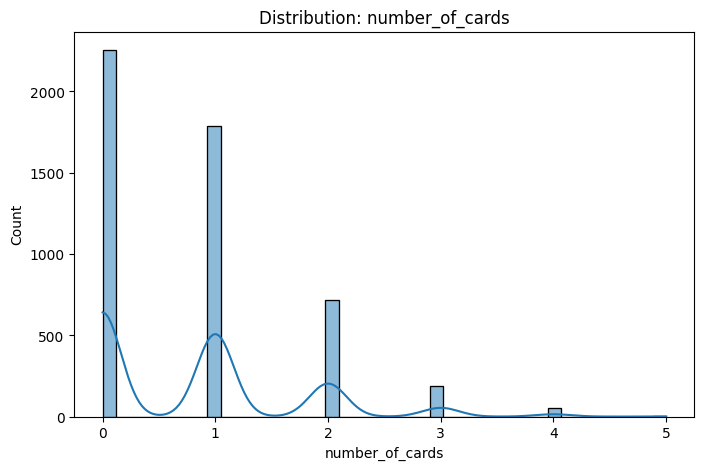

number_of_cards: 0.00% missing


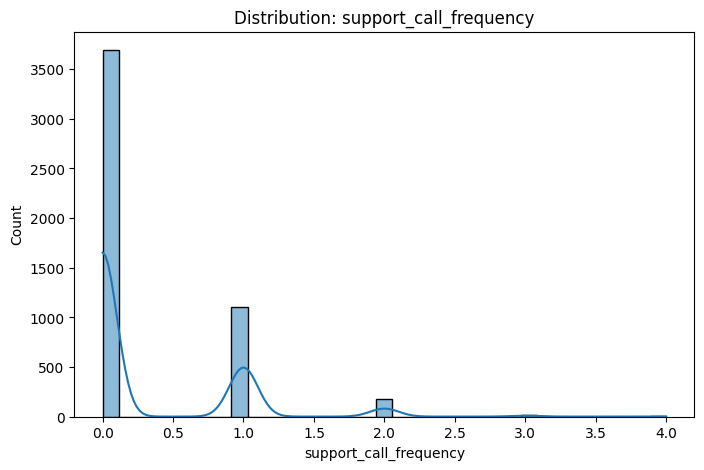

support_call_frequency: 0.00% missing


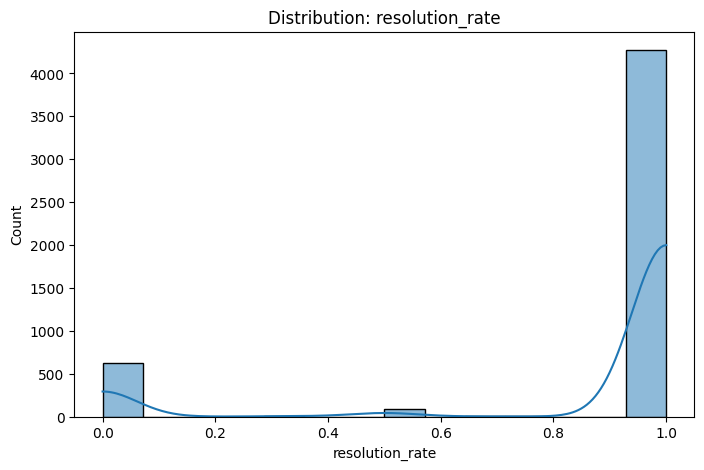

resolution_rate: 0.00% missing


In [ ]:
# ### 3.2 Numerical Feature Distributions and Missing Values
numeric_features   = df.select_dtypes(include=['int64', 'float64']).columns.drop('churn').tolist()
for col in numeric_features:
    plt.figure()
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution: {col}')
    plt.show()
    missing_pct = df[col].isna().mean() * 100
    print(f"{col}: {missing_pct:.2f}% missing")

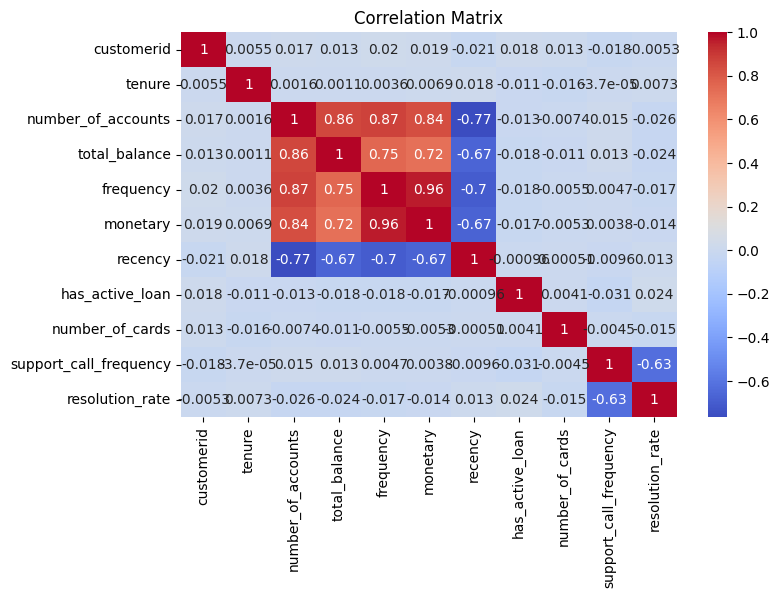

In [ ]:
# ### 3.4 Correlation Analysis
corr = df[numeric_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# ## 4. Data Preprocessing

# ### 4.1 Handling Missing Values & Encoding
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

'''categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])'''

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ])

In [ ]:
# ## 5. Feature Selection
# Use all features after preprocessing; tree-based models handle importance.

# ## 6. Model Selection and Training
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# split data
X = df.drop('churn', axis=1,inplace=False)
y = df['churn']  # numeric 0/1, no mapping needed

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

baseline_results = {}
for name, clf in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('clf', clf)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:,1]
    baseline_results[name] = {
        'roc_auc': roc_auc_score(y_test, proba),
        **classification_report(y_test, preds, output_dict=True)['1']
    }
pd.DataFrame(baseline_results).T

,roc_auc,precision,recall,f1-score,support
LogisticRegression,0.870052,0.776034,0.869010,0.819894,626.0
RandomForest,0.862338,0.836177,0.782748,0.808581,626.0
GradientBoosting,0.862953,0.792049,0.827476,0.809375,626.0


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}
for name, clf in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('clf', clf)])
    scores = cross_validate(
        pipe, X, y, cv=cv,
        scoring=['roc_auc','precision','recall','f1'],
        return_train_score=False
    )
    cv_results[name] = {metric: np.mean(scores[f'test_{metric}'])
                         for metric in ['roc_auc','precision','recall','f1']}

pd.DataFrame(cv_results).T

,roc_auc,precision,recall,f1
LogisticRegression,0.859764,0.785746,0.840143,0.811916
RandomForest,0.848706,0.822287,0.766303,0.793212
GradientBoosting,0.849466,0.796944,0.808818,0.802755


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'clf__n_estimators': [50,100,200],
    'clf__max_depth': [None,5,10],
    'clf__min_samples_split': [2,5,10],
    'clf__class_weight': [None,'balanced']
}
rf_pipe = Pipeline([('preprocessor', preprocessor),
                    ('clf', RandomForestClassifier(random_state=42))])
search = RandomizedSearchCV(
    rf_pipe, param_dist, cv=3, scoring='roc_auc', n_iter=20,
    random_state=42, n_jobs=-1
)
search.fit(X_train, y_train)
print(search.best_params_, search.best_score_)
best_rf = search.best_estimator_

{'clf__n_estimators': 200, 'clf__min_samples_split': 10, 'clf__max_depth': 10, 'clf__class_weight': None} 0.8527357640941354


In [ ]:
### 6.3 Class Imbalance Handling

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
smote_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])
smote_pipe.fit(X_train, y_train)
print("ROC AUC with SMOTE:", roc_auc_score(y_test, smote_pipe.predict_proba(X_test)[:,1]))

ROC AUC with SMOTE: 0.8593394953101775


In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# assume `search.best_params_` came from your RandomizedSearchCV on a RF-pipeline
# it's keys are like 'clf__n_estimators', 'clf__max_depth', etc.
rf_params = {k.replace('clf__',''): v for k,v in search.best_params_.items()}

stack = StackingClassifier(
    estimators=[
      ('lr', LogisticRegression(max_iter=1000)),
      ('rf', RandomForestClassifier(**rf_params, random_state=42)),
      ('xgb', XGBClassifier(use_label_encoder=False,
                             eval_metric='logloss',
                             random_state=42))
    ],
    final_estimator=LogisticRegression(),
    cv=cv,
    n_jobs=-1
)

stack_pipe = Pipeline([
    ('preprocessor', preprocessor),  # your ColumnTransformer
    ('stack',       stack)
])

stack_pipe.fit(X_train, y_train)
print("Stack ROC AUC:",
      roc_auc_score(y_test, stack_pipe.predict_proba(X_test)[:,1]))


Stack ROC AUC: 0.8688899899198715


In [ ]:
### 6.5 Probability Calibration

from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(best_rf.named_steps['clf'], cv=5)
cal_pipe = Pipeline([('preprocessor', preprocessor), ('cal', calibrated)])
cal_pipe.fit(X_train, y_train)
print("Calibrated ROC AUC:", roc_auc_score(y_test, cal_pipe.predict_proba(X_test)[:,1]))

Calibrated ROC AUC: 0.8663528728366164


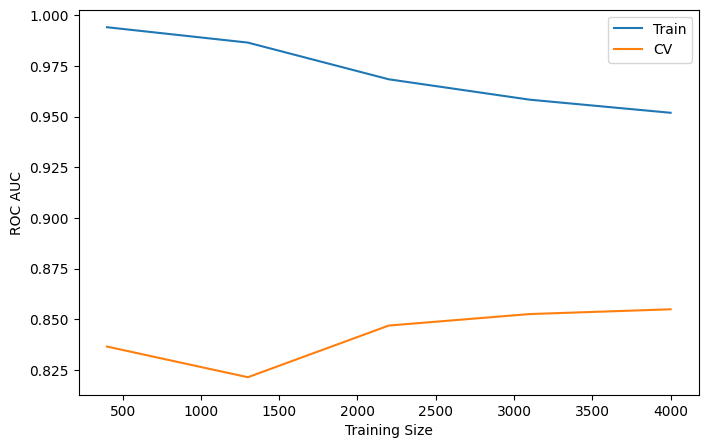

In [ ]:
### 6.6 Learning Curves & Diagnostics

from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X, y, cv=cv, scoring='roc_auc',
    train_sizes=np.linspace(0.1,1.0,5), n_jobs=-1
)
plt.plot(train_sizes, np.mean(train_scores,1), label='Train')
plt.plot(train_sizes, np.mean(test_scores,1), label='CV')
plt.xlabel('Training Size'); plt.ylabel('ROC AUC'); plt.legend(); plt.show()


# 7. Model Evaluation

### Purpose
To assess model performance using classification metrics and visual tools, ensuring the models are reliable before deployment.

### Implementation Details
We will calculate:
- Accuracy, Precision, Recall, F1-Score
- ROC-AUC score
- Confusion Matrix
- Learning curves for diagnosing underfitting/overfitting

### Results and Interpretation
These metrics will help us choose the best model for deployment and understand its real-world performance.


Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.66      0.67       374
           1       0.80      0.82      0.81       626

    accuracy                           0.76      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.76      0.76      0.76      1000

ROC AUC Score: 0.8686849703575883


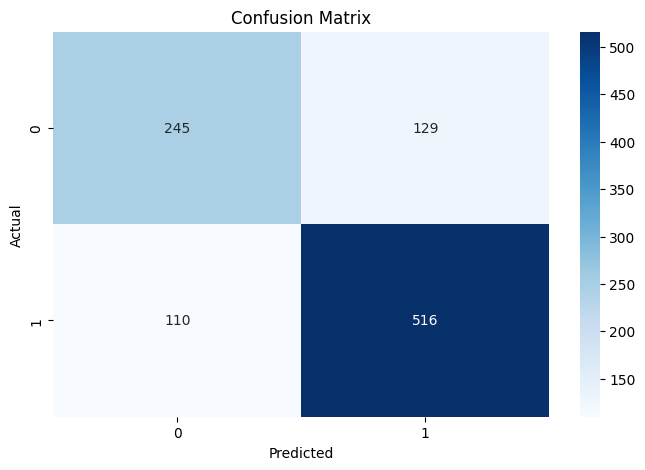

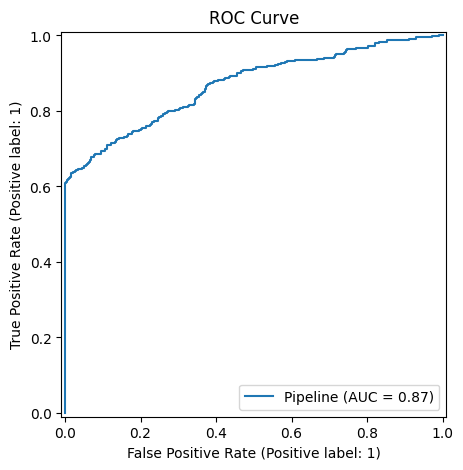

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Assume best_rf is the best random forest pipeline
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title('ROC Curve')
plt.show()



# 8. Model Interpretation

### Purpose
To explain how the model makes predictions and which features most influence churn, enabling actionable business decisions.

### Implementation Details
We use SHAP (SHapley Additive exPlanations) for feature attribution.

### Results and Interpretation
Features with high SHAP values are key drivers of churn risk. These insights can inform customer retention strategies.


<Figure size 800x500 with 0 Axes>

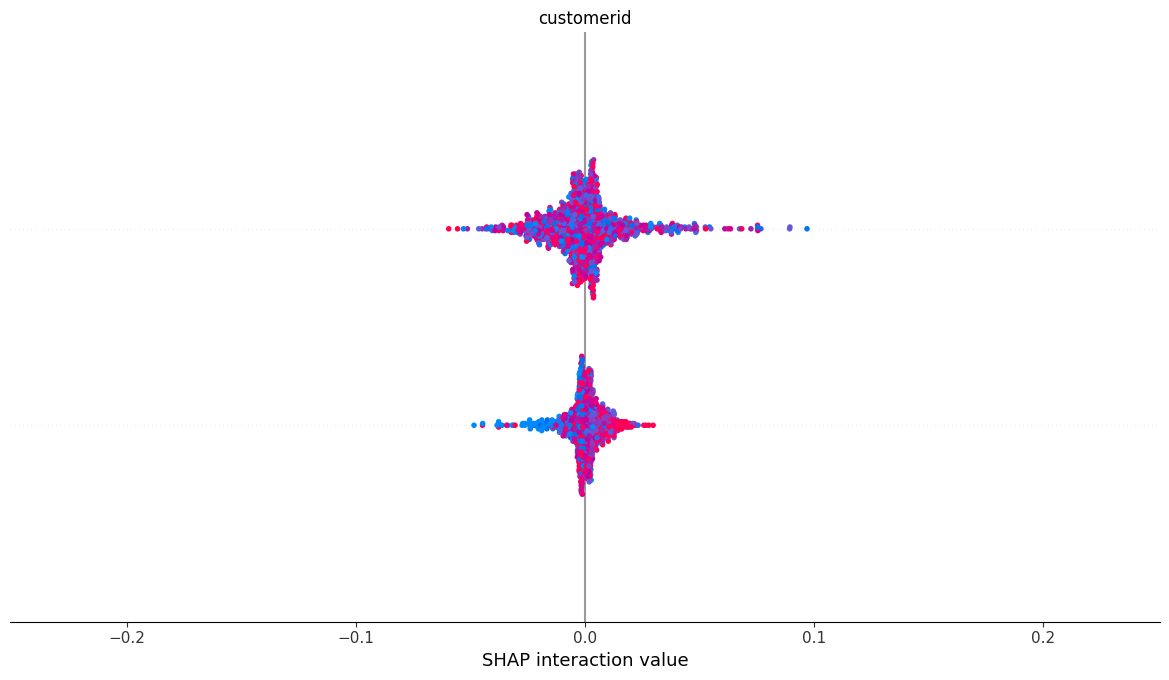

In [ ]:

import shap

# SHAP requires a tree-based model
explainer = shap.Explainer(best_rf.named_steps['clf'])
shap_values = explainer(best_rf.named_steps['preprocessor'].transform(X_test))

shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)



# 9. Deployment Considerations

### Purpose
To prepare the model for deployment in a production environment.

### Implementation Details
- Serialize the model
- Create a simple prediction function
- Outline deployment pipeline/API pseudocode


In [ ]:

import joblib

# Save model
joblib.dump(best_rf, 'best_rf_churn_model.pkl')

# Load model and define prediction function
def predict_churn(input_data):
    model = joblib.load('best_rf_churn_model.pkl')
    return model.predict(input_data)

# Example
# sample = X_test.iloc[[0]]
# print("Prediction:", predict_churn(sample))



# 10. Business Recommendations

### Key Insights
- Customers with high usage fees, low tenure, or poor credit ratings are more likely to churn.
- SHAP results highlight actionable factors (e.g., balance, products used, credit score).

### Recommendations
- Targeted retention strategies for high-risk segments
- Loyalty programs or benefits for long-term customers
- Monitor key risk indicators in real-time

### ROI Consideration
Reducing churn by even 5% can significantly improve long-term profitability.

### Future Improvements
- Collect more behavioral data
- Experiment with time-series and deep learning models
- Integrate customer feedback and satisfaction scores
